In [1]:
# Required Packages

import numpy as np
import pandas as pd

# Display
import progressbar

# Sklearn
from sklearn.model_selection import train_test_split

# Pytorch
import torch
from torch.autograd import Variable
import torch.nn as nn 
import torchvision.transforms as transforms

# Plots
import matplotlib.pyplot as plt

# plt setting
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Digit Recognizer
=====================================

In this article, we use a dataset from [Kaggle.com](https://www.kaggle.com/c/digit-recognizer/data). The problem is solved using

* [Logistic Regression](#Logistic-Regression)
* [Artificial Neural Network (ANN)](#Artificial-Neural-Network-(ANN))

### Data Description from Kaggle.com:

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.
Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.
The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.
Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).
For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.
Visually, if we omit the "pixel" prefix, the pixels make up the image like this:

In [2]:
# loading data
train_data = pd.read_csv("digit_recognizer/train.csv", dtype = np.float32)
display(train_data.head())
print('labels:')
print(np.sort(train_data.label.unique()))

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


labels:
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


We can divide this data into labels and related pixel values. In doing so,

In [3]:
# y set: Labels
y = train_data['label'].values
# X set: Pixels
X = train_data.iloc[:,1:].values/255

For example,

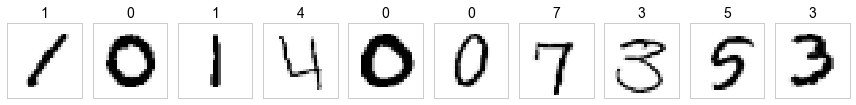

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
n = int(np.sqrt(X[0].shape)[0])
for i in range(len(ax)):
    ax[i].imshow(X[i].reshape(n,n))
    ax[i].set_title('%i' % y[i])
    
fig.tight_layout()

## Train and Test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)
pd.DataFrame(data={'Set':['X_train','X_test','y_train','y_test'],
                   'Shape':[X_train.shape, X_test.shape, y_train.shape, y_test.shape]}).set_index('Set').T

Set,X_train,X_test,y_train,y_test
Shape,"(33600, 784)","(8400, 784)","(33600,)","(8400,)"


In [6]:
# Train and Test Tests

if torch.cuda.is_available():
    X_train_tensor = Variable(torch.from_numpy(X_train).cuda())
    y_train_tensor = Variable(torch.from_numpy(y_train).type(torch.LongTensor).cuda())
    X_test_tensor = Variable(torch.from_numpy(X_test).cuda())
    y_test_tensor = Variable(torch.from_numpy(y_test).type(torch.LongTensor).cuda())
else:
    X_train_tensor = Variable(torch.from_numpy(X_train))
    y_train_tensor = Variable(torch.from_numpy(y_train).type(torch.LongTensor))
    X_test_tensor = Variable(torch.from_numpy(X_test))
    y_test_tensor = Variable(torch.from_numpy(y_test).type(torch.LongTensor))
    

Batch_size = 100
iteration_number = 1e4

epochs_number = int(iteration_number / (len(X_train) / Batch_size))

# Pytorch train and test sets
Train_set = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
Test_set = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# data loader
train_loader = torch.utils.data.DataLoader(Train_set, batch_size = Batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(Train_set, batch_size = Batch_size, shuffle = False)

del X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, Train_set, Test_set

# Logistic Regression

We have talked about the [Logistic Regression](https://hatefdastour.github.io/notes/Statistical_Learning/Logistic_Regression.html) using [sklearn ](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Here, we would like to try the logistic regression  iteratively using an optimization algorithm. The algorithm at each iteration uses the [Cross-Entropy Loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html) to measure the loss, and then the gradient and the model update is calculated. At the end of this iterative process, we would reach a better level of agreement between test and predicted sets since the error would be lower from that of the first step.

In [7]:
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, input_Size, output_Size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(input_Size, output_Size)
    
    def forward(self, x):
        out = self.linear(x)
        return out

|=========================================================================|100%


Iteration,Loss,Accuracy
50,1.908081,64.958336
800,0.7540457,85.64285
1550,0.42494375,87.56845
2300,0.3712406,88.440475
3050,0.51598907,88.98214
3800,0.48802415,89.40774
4550,0.39292473,89.73214
5300,0.37484547,89.934525
6050,0.37746385,90.13988
6800,0.28905842,90.375


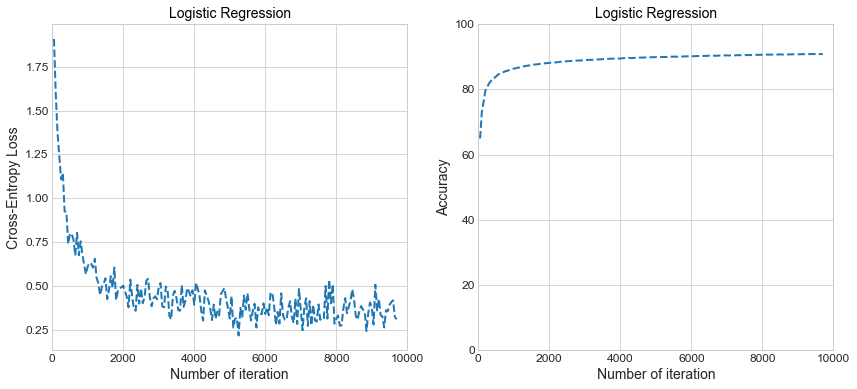

In [8]:
input_Size, output_Size = len(X[0]), len(np.unique(y))

# model
model = LogisticRegressionModel(input_Size, output_Size)

# GPU
if torch.cuda.is_available():
    model.cuda()

# Cross Entropy Loss 
CEL= nn.CrossEntropyLoss()

# Optimizer 
learning_rate = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Traning the Model
Count = 0
loss_list = []
Iteration_list = []
Accuracy_list = []
Steps = 50

Progress_Bar = progressbar.ProgressBar(maxval= iteration_number,
                                       widgets=[progressbar.Bar('=', '|', '|'),
                                                progressbar.Percentage()])
# print('---------------------------------------------------------')
for epoch in range(epochs_number):
    for i, (X_train_tensor, y_train_tensor) in enumerate(train_loader):
        
        # Variables
        X_train_tensor = Variable(X_train_tensor.view(-1, X[0].shape[0]))
        y_train_tensor = Variable(y_train_tensor)
        
        # Set all gradients to zero
        optimizer.zero_grad()
        
        # Forward
        Out = model(X_train_tensor)
        
        # CEL
        loss = CEL(Out, y_train_tensor)
        
        # Backward (Calculating the gradients)
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        Count += 1
        
        # Predictions
        if Count % Steps == 0:
            # Calculate Accuracy         
            Correct, Total = 0, 0
            # Predictions
            for X_test_tensor, y_train_tensor in test_loader: 
                X_test_tensor = Variable(X_test_tensor.view(-1, X[0].shape[0]))
                
                # Forward
                Out = model(X_test_tensor)
                
                # The maximum value of Out
                Predicted = torch.max(Out.data, 1)[1]
                
                # Total number of y_train_tensor
                Total += len(y_train_tensor)
                
                # Total Correct predictions
                Correct += (Predicted == y_train_tensor).sum()
            
            Accuracy = 100 * (Correct / float(Total))
            
            # store loss and iteration
            loss_list.append(loss.data)
            Iteration_list.append(Count)
            Accuracy_list.append(Accuracy)
            
#         if Count % Steps == 0:
#             # Print Loss
#             print('Iteration: %i,  Loss: %.4f and  Accuracy: %.4f' % (Count, loss.data, Accuracy))

        Progress_Bar.update(Count)

Progress_Bar.finish()
# print('---------------------------------------------------------')

fig, ax = plt.subplots(1, 2, figsize=(14,6))
_ = ax[0].plot(Iteration_list, loss_list, linestyle='dashed', linewidth=2)
_ = ax[0].set_xlabel("Number of iteration")
_ = ax[0].set_ylabel("Cross-Entropy Loss")
_ = ax[0].set_title("Logistic Regression")
_ = ax[0].set_xlim([0,iteration_number])

_ = ax[1].plot(Iteration_list, Accuracy_list, linestyle='dashed', linewidth=2)
_ = ax[1].set_xlabel("Number of iteration")
_ = ax[1].set_ylabel("Accuracy")
_ = ax[1].set_title("Logistic Regression")
_ = ax[1].set_xlim([0,iteration_number])
_ = ax[1].set_ylim([0,100])
Table = pd.DataFrame({'Iteration':Iteration_list,
                      'Loss': [x.cpu().numpy() for x in loss_list],
                      'Accuracy': [x.cpu().numpy() for x in Accuracy_list]})
display(Table[0:-1:15].style.hide_index())

# Artificial Neural Network (ANN)

The second method that we would like to try is the Artificial Neural Network. Interested readers are encouraged to read some of the great available resources such as [[1](https://en.wikipedia.org/wiki/Artificial_neural_network), [2](https://www.sciencedirect.com/topics/earth-and-planetary-sciences/artificial-neural-network)]. Here, our model uses three hidden layers.


<img src='https://www.i2tutorials.com/wp-content/uploads/2019/09/Deep-learning-40-i2tutorials.png' width='600' align="center"/>


In [9]:
# Create ANN Model
class ANNModel(nn.Module):
    def __init__(self, input_Size, hidden_Size, output_Size):
        super(ANNModel, self).__init__()
        # Linear function 1:
        self.fc1 = nn.Linear(input_Size, hidden_Size) 
        # Non-linearity 1
        self.relu1 = nn.ReLU()
        
        # Linear function 2:
        self.fc2 = nn.Linear(hidden_Size, hidden_Size)
        # Non-linearity 2
        self.tanh2 = nn.Tanh()
        
        # Linear function 3:
        self.fc3 = nn.Linear(hidden_Size, hidden_Size)
        # Non-linearity 3
        self.elu3 = nn.ELU()
        
        # Linear function 4:
        self.fc4 = nn.Linear(hidden_Size, output_Size)  
    
    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)
        
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.tanh2(out)
        
        # Linear function 2
        out = self.fc3(out)
        # Non-linearity 2
        out = self.elu3(out)
        
        # Linear function 4 (readout)
        out = self.fc4(out)
        return out

|=========================================================================|100%


Iteration,Loss,Accuracy
50,2.283844,22.845238
800,0.69324845,83.09524
1550,0.23171382,90.065475
2300,0.18222879,91.627975
3050,0.33375826,93.0
3800,0.22443426,94.34524
4550,0.16940738,95.104164
5300,0.16704533,95.860115
6050,0.11682404,96.4494
6800,0.0977621,96.78274


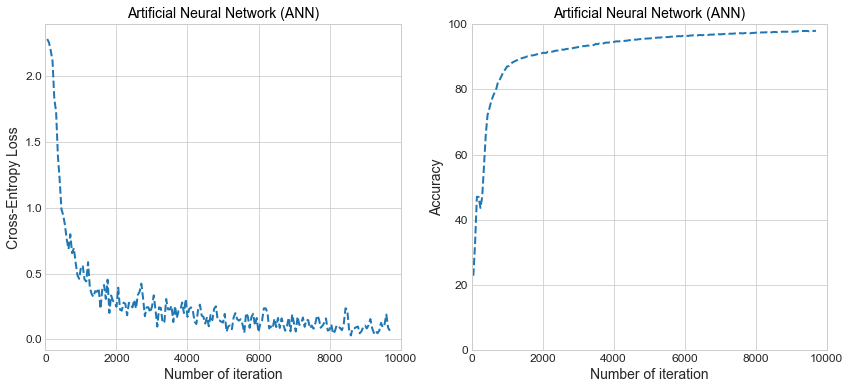

In [10]:
input_Size, output_Size = len(X[0]), len(np.unique(y))
hidden_Size = 100


# Create ANN
model = ANNModel(input_Size, hidden_Size, output_Size)

# GPU
if torch.cuda.is_available():
    model.cuda()
    
# Cross Entropy Loss 
CEL = nn.CrossEntropyLoss()

# Optimizer 
learning_rate = 2e-2
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Traning the Model
Count = 0
loss_list = []
Iteration_list = []
Accuracy_list = []
Steps = 50

Progress_Bar = progressbar.ProgressBar(maxval= iteration_number,
                                       widgets=[progressbar.Bar('=', '|', '|'),
                                                progressbar.Percentage()])
# print('---------------------------------------------------------')
for epoch in range(epochs_number):
    for i, (X_train_tensor, y_train_tensor) in enumerate(train_loader):
        
        # Variables
        X_train_tensor = Variable(X_train_tensor.view(-1, X[0].shape[0]))
        y_train_tensor = Variable(y_train_tensor)
        
        # Set all gradients to zero
        optimizer.zero_grad()
        
        # Forward
        Out = model(X_train_tensor)
        
        # CEL
        loss = CEL(Out, y_train_tensor)
        
        # Backward (Calculating the gradients)
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        Count += 1
        
        # Predictions
        if Count % Steps == 0:
            # Calculate Accuracy         
            Correct, Total = 0, 0
            # Predictions
            for X_test_tensor, y_train_tensor in test_loader: 
                X_test_tensor = Variable(X_test_tensor.view(-1, X[0].shape[0]))
                
                # Forward
                Out = model(X_test_tensor)
                
                # The maximum value of Out
                Predicted = torch.max(Out.data, 1)[1]
                
                # Total number of y_train_tensor
                Total += len(y_train_tensor)
                
                # Total Correct predictions
                Correct += (Predicted == y_train_tensor).sum()
            
            Accuracy = 100 * (Correct / float(Total))
            
            # store loss and iteration
            loss_list.append(loss.data)
            Iteration_list.append(Count)
            Accuracy_list.append(Accuracy)
            
#         if Count % Steps == 0:
#             # Print Loss
#             print('Iteration: %i,  Loss: %.4f and  Accuracy: %.4f' % (Count, loss.data, Accuracy))

        Progress_Bar.update(Count)

Progress_Bar.finish()
# print('---------------------------------------------------------')

fig, ax = plt.subplots(1, 2, figsize=(14,6))
_ = ax[0].plot(Iteration_list, loss_list, linestyle='dashed', linewidth=2)
_ = ax[0].set_xlabel("Number of iteration")
_ = ax[0].set_ylabel("Cross-Entropy Loss")
_ = ax[0].set_title("Artificial Neural Network (ANN)")
_ = ax[0].set_xlim([0,iteration_number])

_ = ax[1].plot(Iteration_list, Accuracy_list, linestyle='dashed', linewidth=2)
_ = ax[1].set_xlabel("Number of iteration")
_ = ax[1].set_ylabel("Accuracy")
_ = ax[1].set_title("Artificial Neural Network (ANN)")
_ = ax[1].set_xlim([0,iteration_number])
_ = ax[1].set_ylim([0,100])
Table = pd.DataFrame({'Iteration':Iteration_list,
                      'Loss': [x.cpu().numpy() for x in loss_list],
                      'Accuracy': [x.cpu().numpy() for x in Accuracy_list]})
display(Table[0:-1:15].style.hide_index())

***